In [88]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the delta_CDR for 
# the CDR potential runs and filtering out the 
# regions that lead to undesirable soil outcomes
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# *** initialize profile vars
varin1 = "solid_weightPercent"
varin2 = "aqueous"
varsuff = "batch"
dustsp_sil = "gbas"
dustsp_cc = "cc"

# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "hi"
idx_1 = "003"
tag_sil_1 = "basev1"

# FERT LEVEL 2
fertLevel_2 = "low"
idx_2 = "003"
tag_sil_2 = "basev1"



In [89]:
# ---- READ IN DATA
# FERT LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))
# read in profile data
dssil1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
dscc1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
dssil1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
dscc1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

# FERT LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))
# read in profile data
dssil2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
dscc2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
dssil2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
dscc2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))


In [90]:
# --- add [solid weight percent] to ds_anom data
tmax = 15    # only pull out the last timeslice

# silicate
dssil1_v1 = dssil1_v1.sel(time=tmax, method='nearest').expand_dims(feedstock=["gbas"]).copy()
dssil2_v1 = dssil2_v1.sel(time=tmax, method='nearest').expand_dims(feedstock=["gbas"]).copy()
# carbonate
dscc1_v1 = dscc1_v1.sel(time=tmax, method='nearest').expand_dims(feedstock=["cc"]).copy()
dscc2_v1 = dscc2_v1.sel(time=tmax, method='nearest').expand_dims(feedstock=["cc"]).copy()

# merge datasets -- fert level 1
ds_anom1 = xr.merge([ds_anom1, dssil1_v1['gbas'], dssil1_v1['gbas_coredep'], dscc1_v1['cc'], dscc1_v1['cc_coredep']]).copy()
# merge datasets -- fert level 2
ds_anom2 = xr.merge([ds_anom2, dssil2_v1['gbas'], dssil2_v1['gbas_coredep'], dscc2_v1['cc'], dscc2_v1['cc_coredep']]).copy()


In [91]:
# --- add [aqueous ph] to ds_anom data 
# silicate
dssil1_v2 = dssil1_v2.sel(time=tmax, method='nearest').expand_dims(feedstock=["gbas"]).copy()
dssil2_v2 = dssil2_v2.sel(time=tmax, method='nearest').expand_dims(feedstock=["gbas"]).copy()
# carbonate
dscc1_v2 = dscc1_v2.sel(time=tmax, method='nearest').expand_dims(feedstock=["cc"]).copy()
dscc2_v2 = dscc2_v2.sel(time=tmax, method='nearest').expand_dims(feedstock=["cc"]).copy()

# merge datasets -- fert level 1
ds_anom1 = xr.merge([ds_anom1, dssil1_v2['ph'], dssil1_v2['ph_coredep'], dscc1_v2['ph'], dscc1_v2['ph_coredep']]).copy()
# merge datasets -- fert level 2
ds_anom2 = xr.merge([ds_anom2, dssil2_v2['ph'], dssil2_v2['ph_coredep'], dscc2_v2['ph'], dscc2_v2['ph_coredep']]).copy()


## Plot 1: warm-up with just the netCDR by itself

In [92]:
ds_anom1

<xarray.Dataset> Size: 5MB
Dimensions:                  (loss_percent: 50, dustrate_ton_ha_yr: 15,
                              dustrad: 10, cdr_calc: 5, feedstock: 2, depth: 30)
Coordinates:
  * loss_percent             (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr       (dustrate_ton_ha_yr) float64 120B 0.0 0.1 ... 100.0
  * dustrad                  (dustrad) int32 40B 1 10 30 50 ... 125 150 200 300
  * cdr_calc                 (cdr_calc) object 40B 'netR' ... 'conservative'
  * feedstock                (feedstock) object 16B 'cc' 'gbas'
  * depth                    (depth) float64 240B 0.008333 0.025 ... 0.4917
    time                     float64 8B 15.0
Data variables: (12/17)
    cdr_dif                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    cdr_adv                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    cdr_adv_plus_newSIC      (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    cdr_SIConly              (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    co2pot_tot_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    co2pot_adv_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    ...                       ...
    gbas                     (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    gbas_coredep             (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    cc                       (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    cc_coredep               (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    ph                       (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    ph_coredep               (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...

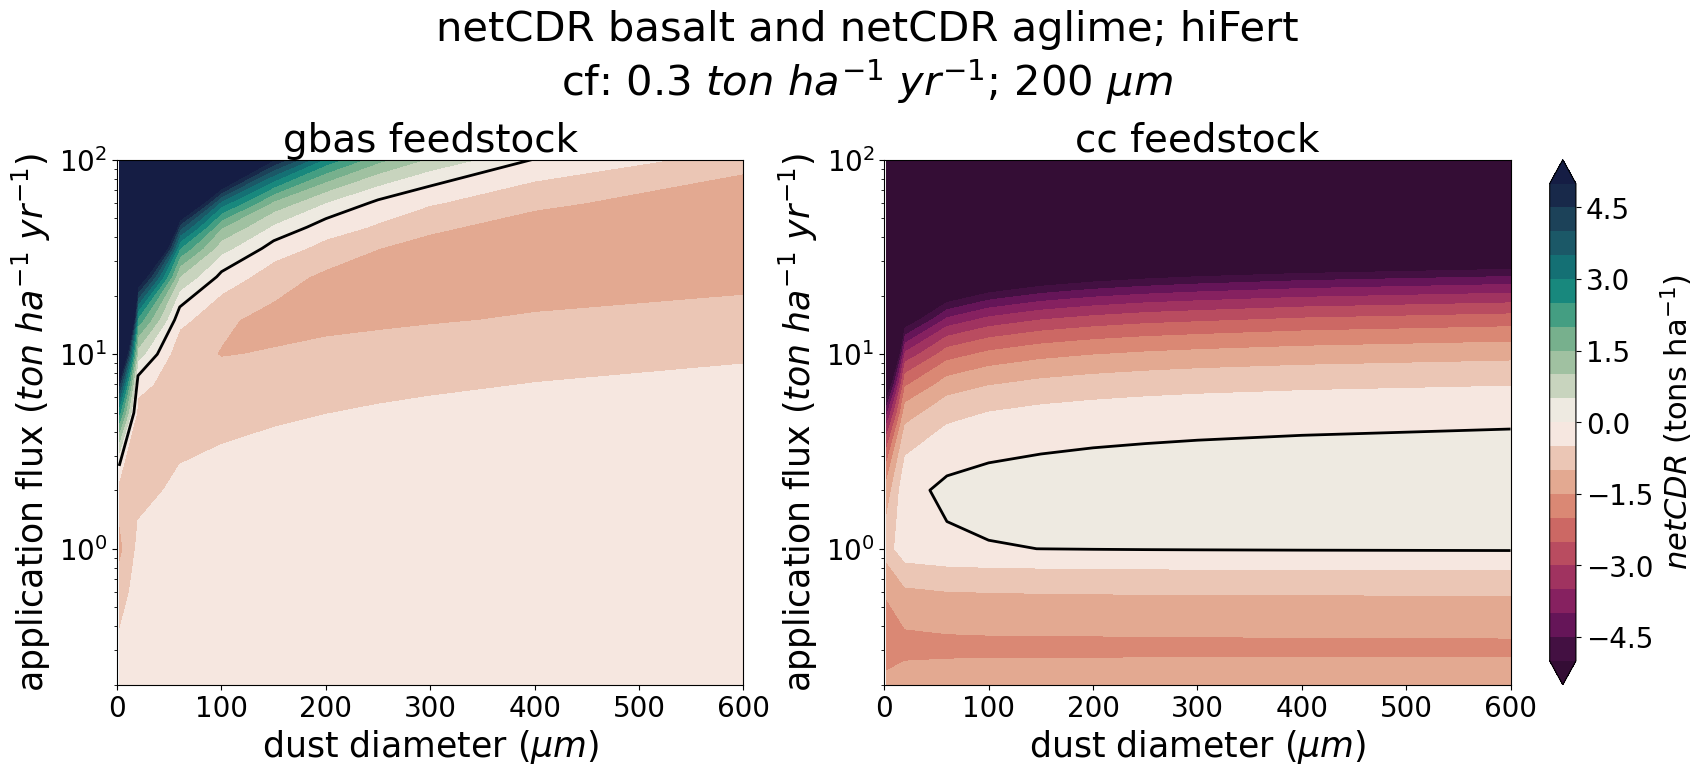

In [93]:
# --- PLOT --------------------
# set data conditions
fsname_sil, fsname_cc = 'gbas', 'cc'
fertcase = 1
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'conservative' # 'netR_noNeg' # 'conservative'
logX = False
logY = True

# pull out the data we want
if fertcase == 1:
    dsanom_sil = ds_anom1.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom1.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_1
if fertcase == 2:
    dsanom_sil = ds_anom2.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom2.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_2

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom_sil = dsanom_sil.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_cc = dsanom_cc.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 100 
# *****************************

# x and y arrays
# [sil fs]
x1 = dsanom_sil['dustrad'].values
y1 = dsanom_sil['dustrate_ton_ha_yr'].values
# [cc fs]
x2 = dsanom_cc['dustrad'].values
y2 = dsanom_cc['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom_sil.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom_sil.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt and netCDR aglime; {tfert}Fert\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fsname_sil} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsanom_cc.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom_cc.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fsname_cc} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


## Plot 2: hatch over areas we don't want

In [94]:
ds_anom1

<xarray.Dataset> Size: 5MB
Dimensions:                  (loss_percent: 50, dustrate_ton_ha_yr: 15,
                              dustrad: 10, cdr_calc: 5, feedstock: 2, depth: 30)
Coordinates:
  * loss_percent             (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr       (dustrate_ton_ha_yr) float64 120B 0.0 0.1 ... 100.0
  * dustrad                  (dustrad) int32 40B 1 10 30 50 ... 125 150 200 300
  * cdr_calc                 (cdr_calc) object 40B 'netR' ... 'conservative'
  * feedstock                (feedstock) object 16B 'cc' 'gbas'
  * depth                    (depth) float64 240B 0.008333 0.025 ... 0.4917
    time                     float64 8B 15.0
Data variables: (12/17)
    cdr_dif                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    cdr_adv                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    cdr_adv_plus_newSIC      (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    cdr_SIConly              (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    co2pot_tot_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    co2pot_adv_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 600kB ...
    ...                       ...
    gbas                     (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    gbas_coredep             (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    cc                       (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    cc_coredep               (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    ph                       (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...
    ph_coredep               (feedstock, dustrate_ton_ha_yr, dustrad, depth) float64 72kB ...

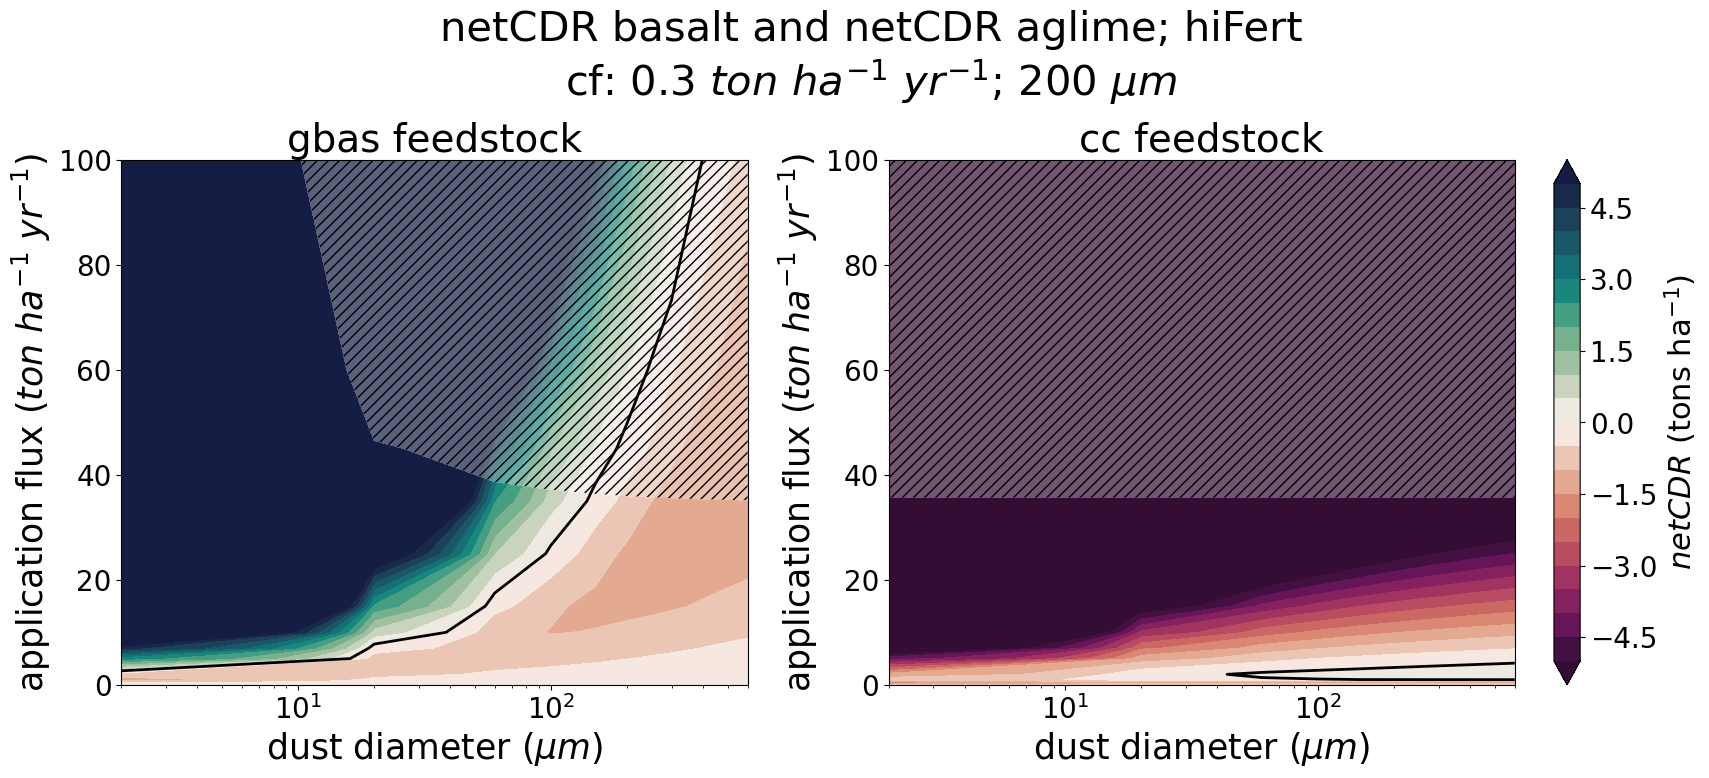

In [95]:
# --- PLOT --------------------
# set data conditions
fsname_sil, fsname_cc = 'gbas', 'cc'
fertcase = 1
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'conservative' # 'netR_noNeg' # 'conservative'
hatchby = "mineral"     # [mineral, ph] 
hatchdep = 0.08
hatch_threshold = 8
logX = True
logY = False

# pull out the data we want
hvarsil = dustsp_sil if hatchby == "mineral" else "ph"
hvarcc = dustsp_cc if hatchby == "mineral" else "ph"
if fertcase == 1:
    dsanom_sil = ds_anom1.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom1.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_1
    # get the hatching var 
    dsanom_hatch_sil = ds_anom1.sel(feedstock=fsname_sil).sel(depth=hatchdep, method='nearest')[hvarsil]
    dsanom_hatch_cc = ds_anom1.sel(feedstock=fsname_cc).sel(depth=hatchdep, method='nearest')[hvarcc]
if fertcase == 2:
    dsanom_sil = ds_anom2.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom2.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_2
    # get the hatching var 
    dsanom_hatch_sil = ds_anom1.sel(feedstock=fsname_sil).sel(depth=hatchdep, method='nearest')[hvarsil]
    dsanom_hatch_cc = ds_anom1.sel(feedstock=fsname_cc).sel(depth=hatchdep, method='nearest')[hvarcc]
    

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom_sil = dsanom_sil.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_cc = dsanom_cc.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_hatch_sil = dsanom_hatch_sil.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_hatch_cc = dsanom_hatch_cc.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
hatchtype = '///'   # ['///', 'xxx']
hatchcolor = "white"  # "none", ...
hatch_bgalpha = 0.3
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 100 
# *****************************

# x and y arrays
# [sil fs]
x1 = dsanom_sil['dustrad'].values
y1 = dsanom_sil['dustrate_ton_ha_yr'].values
# [cc fs]
x2 = dsanom_cc['dustrad'].values
y2 = dsanom_cc['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# check that hatch min,max are in the right order
hmaxsil = dsanom_hatch_sil.max() if dsanom_hatch_sil.max() > hatch_threshold else hatch_threshold + 1
hmaxcc = dsanom_hatch_cc.max() if dsanom_hatch_cc.max() > hatch_threshold else hatch_threshold + 1

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- feedstock 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom_sil.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom_sil.transpose(),levels=[0], colors='black', linewidths=2)
# add hatching
hatch = plt.contourf(x1*2,y1, dsanom_hatch_sil, levels=[hatch_threshold, hmaxsil], 
                    colors=hatchcolor, alpha=hatch_bgalpha, hatches=[hatchtype])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt and netCDR aglime; {tfert}Fert\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fsname_sil} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- feedstock 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsanom_cc.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom_cc.transpose(),levels=[0], colors='black', linewidths=2)
# add hatching
hatch = plt.contourf(x2*2,y2, dsanom_hatch_cc, levels=[hatch_threshold, hmaxcc], 
        colors=hatchcolor, alpha=hatch_bgalpha, hatches=[hatchtype])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fsname_cc} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


## Plot 3: both hatch limits at once

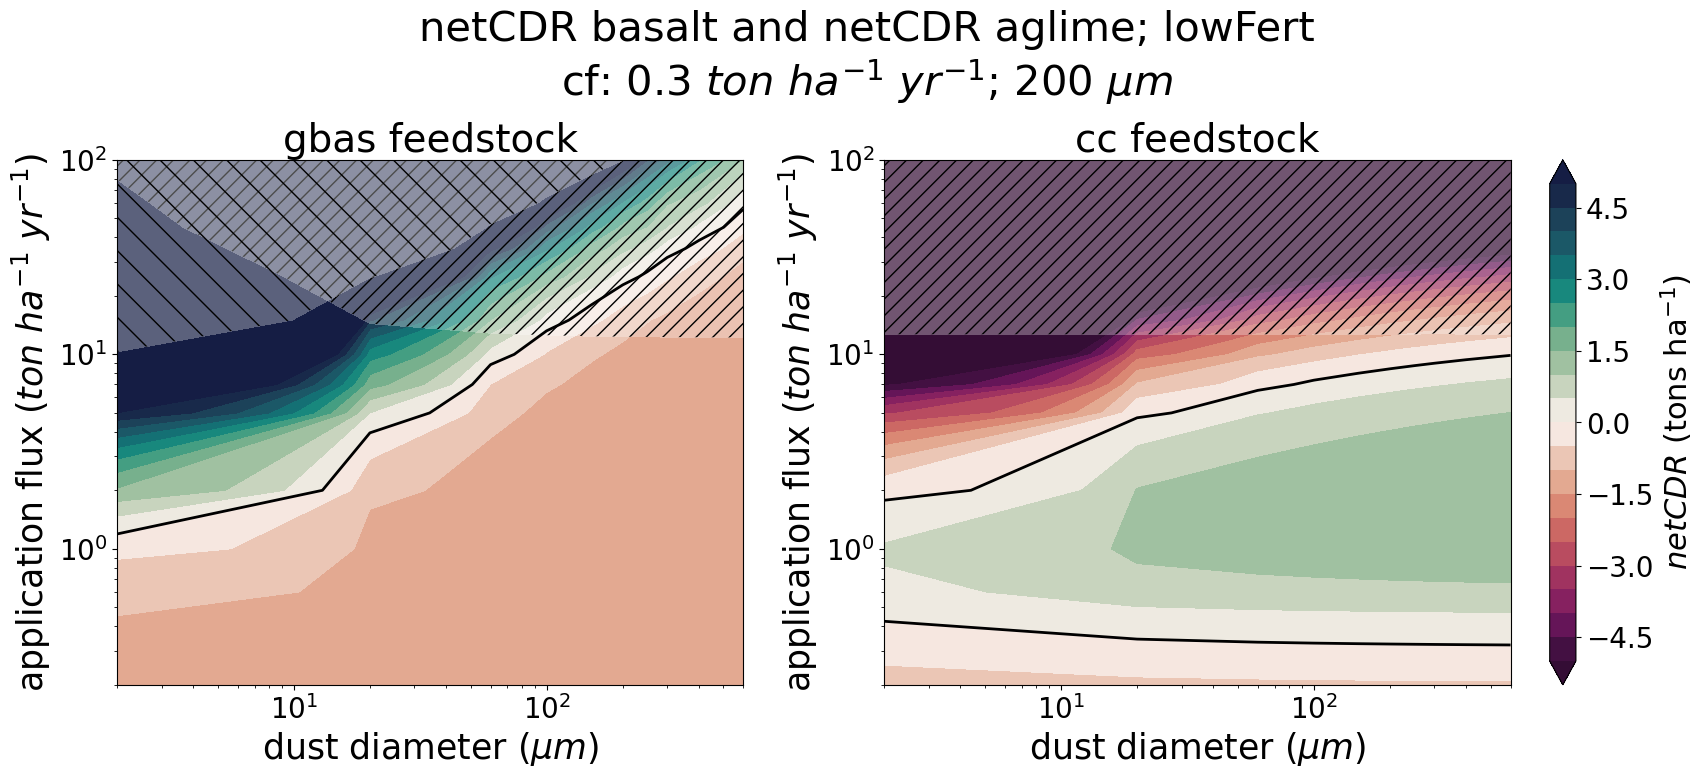

In [96]:
# --- PLOT --------------------
# set data conditions
fsname_sil, fsname_cc = 'gbas', 'cc'
fertcase = 2
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'conservative' # 'netR_noNeg' # 'conservative'
hatchdep = 0.05
hatch_threshold1 = 5  # wt% mineral
hatch_threshold2 = 8   # ph
logX = True
logY = True

# pull out the data we want
hvarsil1, hvarsil2 = dustsp_sil, "ph"
hvarcc1, hvarcc2 = dustsp_cc, "ph"
if fertcase == 1:
    dsanom_sil = ds_anom1.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom1.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_1
    # get the hatching var 
    dsanom_hatch_sil1 = ds_anom1.sel(feedstock=fsname_sil).sel(depth=hatchdep, method='nearest')[hvarsil1]
    dsanom_hatch_cc1 = ds_anom1.sel(feedstock=fsname_cc).sel(depth=hatchdep, method='nearest')[hvarcc1]
    dsanom_hatch_sil2 = ds_anom1.sel(feedstock=fsname_sil).sel(depth=hatchdep, method='nearest')[hvarsil2]
    dsanom_hatch_cc2 = ds_anom1.sel(feedstock=fsname_cc).sel(depth=hatchdep, method='nearest')[hvarcc2]
if fertcase == 2:
    dsanom_sil = ds_anom2.sel(feedstock=fsname_sil, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    dsanom_cc = ds_anom2.sel(feedstock=fsname_cc, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
    tfert =fertLevel_2
    # get the hatching var 
    dsanom_hatch_sil1 = ds_anom1.sel(feedstock=fsname_sil).sel(depth=hatchdep, method='nearest')[hvarsil1]
    dsanom_hatch_cc1 = ds_anom1.sel(feedstock=fsname_cc).sel(depth=hatchdep, method='nearest')[hvarcc1]
    dsanom_hatch_sil2 = ds_anom1.sel(feedstock=fsname_sil).sel(depth=hatchdep, method='nearest')[hvarsil2]
    dsanom_hatch_cc2 = ds_anom1.sel(feedstock=fsname_cc).sel(depth=hatchdep, method='nearest')[hvarcc2]
    

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom_sil = dsanom_sil.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_cc = dsanom_cc.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_hatch_sil1 = dsanom_hatch_sil1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_hatch_cc1 = dsanom_hatch_cc1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_hatch_sil2 = dsanom_hatch_sil2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom_hatch_cc2 = dsanom_hatch_cc2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()



# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
hatchtype1, hatchtype2 = '//', '\\'   # ['///', 'xxx']
hatchcolor1, hatchcolor2 = "white", "white"  # "none", ...
hatch_bgalpha1, hatch_bgalpha2 = 0.3, 0.3
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 100 
# *****************************

# x and y arrays
# [sil fs]
x1 = dsanom_sil['dustrad'].values
y1 = dsanom_sil['dustrate_ton_ha_yr'].values
# [cc fs]
x2 = dsanom_cc['dustrad'].values
y2 = dsanom_cc['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# check that hatch min,max are in the right order
hmaxsil1 = dsanom_hatch_sil1.max() if dsanom_hatch_sil1.max() > hatch_threshold1 else hatch_threshold1 + 1
hmaxcc1 = dsanom_hatch_cc1.max() if dsanom_hatch_cc1.max() > hatch_threshold1 else hatch_threshold1 + 1
hmaxsil2 = dsanom_hatch_sil2.max() if dsanom_hatch_sil2.max() > hatch_threshold2 else hatch_threshold2 + 1
hmaxcc2 = dsanom_hatch_cc2.max() if dsanom_hatch_cc2.max() > hatch_threshold2 else hatch_threshold2 + 1

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- feedstock 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom_sil.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom_sil.transpose(),levels=[0], colors='black', linewidths=2)
# add hatching
hatch1 = plt.contourf(x1*2,y1, dsanom_hatch_sil1, levels=[hatch_threshold1, hmaxsil1], 
                    colors=hatchcolor1, alpha=hatch_bgalpha1, hatches=[hatchtype1])
hatch2 = plt.contourf(x1*2,y1, dsanom_hatch_sil2, levels=[hatch_threshold2, hmaxsil2], 
                    colors=hatchcolor2, alpha=hatch_bgalpha2, hatches=[hatchtype2])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt and netCDR aglime; {tfert}Fert\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fsname_sil} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- feedstock 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsanom_cc.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom_cc.transpose(),levels=[0], colors='black', linewidths=2)
# add hatching
hatch1 = plt.contourf(x2*2,y2, dsanom_hatch_cc1, levels=[hatch_threshold1, hmaxcc1], 
                    colors=hatchcolor1, alpha=hatch_bgalpha1, hatches=[hatchtype1])
hatch2 = plt.contourf(x2*2,y2, dsanom_hatch_cc2, levels=[hatch_threshold2, hmaxcc2], 
                    colors=hatchcolor2, alpha=hatch_bgalpha2, hatches=[hatchtype2])
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fsname_cc} feedstock", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


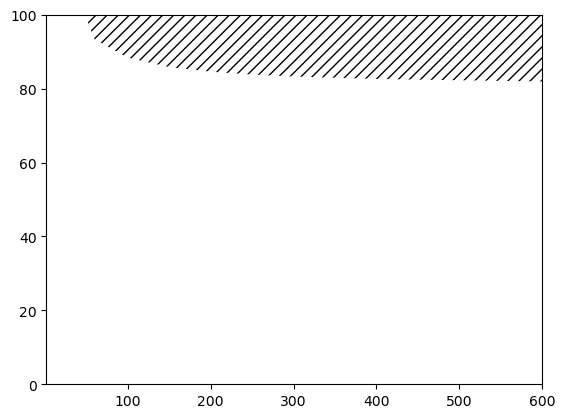

In [46]:
plt.contourf(x1*2,y1, dsanom_hatch_sil, levels=[hatch_threshold, dsanom_hatch_sil.max()], colors='none', hatches=['///'])

In [43]:
dustsp_sil if hatchby == "mineral" else "ph"

'gbas'